In [0]:
import pandas as pd
import time
import re
import numpy as np

In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_path = '/content/drive/My Drive/DSA4261 Supply Chain and Logistics/Project 1 Data /2017/'

def get_data(data_path,year,month,zone):
    data = pd.read_csv(data_path + "ais_southern_ships_{}_{}_zone{}_reduce.csv".format(str(year),str(month),str(zone)))
    return data

def get_yearly_data(data_path,year,zone):
    df = pd.DataFrame()
    for i in range(1,12):
        data = get_data(data_path,str(year),"%02d" % i,str(zone))
        df = pd.concat([df,data],axis=0)
    return df

In [0]:
df = get_yearly_data(data_path,2017,15)
df = df.dropna(subset=['LAT','LON']).reset_index(drop=True)

In [0]:
from datetime import datetime
basedatetime_utc = df['BaseDateTime'].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.0000000Z'))
basedatetime_unix = df['BaseDateTime'].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.0000000Z').timestamp())
date = df['BaseDateTime'].apply(lambda x:x[:10])

In [0]:
df['BaseDateTime_UTC'] = basedatetime_utc
df['BaseDateTime_UNIX'] = basedatetime_unix
df['MMSI'] = df['MMSI'].astype(str)
df['Date'] = date

In [0]:
df = df.sort_values(by=['MMSI','BaseDateTime_UTC'])
df = df.reset_index(drop=True)
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,BaseDateTime_UTC,BaseDateTime_UNIX,Date
0,0,2017-01-24T08:27:12.0000000Z,18.12518,-94.41903,0.0,-195.6,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,0.0,0.0,2017-01-24 08:27:12,1.485246e+09,2017-01-24
1,0,2017-01-24T08:29:42.0000000Z,18.12518,-94.41903,0.0,-195.6,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 08:29:42,1.485247e+09,2017-01-24
2,0,2017-01-24T08:47:42.0000000Z,18.12518,-94.41903,0.0,-195.7,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 08:47:42,1.485248e+09,2017-01-24
3,0,2017-01-24T09:05:21.0000000Z,18.12519,-94.41902,0.0,-195.4,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 09:05:21,1.485249e+09,2017-01-24
4,0,2017-01-24T20:56:52.0000000Z,18.79671,-93.43659,11.8,58.5,59.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 20:56:52,1.485291e+09,2017-01-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028820,999999999,2017-09-15T05:31:09.0000000Z,18.98631,-95.88587,14.1,136.9,135.0,62 MCKINNA,NaN,NaN,30.0,undefined,0.0,0.0,0.0,55.0,2017-09-15 05:31:09,1.505453e+09,2017-09-15
1028821,999999999,2017-09-15T05:32:27.0000000Z,18.98256,-95.88216,14.1,137.3,135.0,62 MCKINNA,NaN,NaN,30.0,undefined,0.0,0.0,0.0,55.0,2017-09-15 05:32:27,1.505454e+09,2017-09-15
1028822,999999999,2017-09-15T05:34:09.0000000Z,18.98084,-95.87597,14.1,76.4,78.0,62 MCKINNA,NaN,NaN,30.0,undefined,0.0,0.0,0.0,55.0,2017-09-15 05:34:09,1.505454e+09,2017-09-15
1028823,999999999,2017-09-15T05:38:16.0000000Z,18.98562,-95.85971,14.3,73.3,76.0,62 MCKINNA,NaN,NaN,30.0,undefined,0.0,0.0,0.0,55.0,2017-09-15 05:38:16,1.505454e+09,2017-09-15


**Mapping VesselTypeCode to VesselType?**
*Fishing, Tanker, Tug Tow, Cargo, etc..*

In [0]:
vessel_info_df = pd.read_csv('/content/drive/My Drive/DSA4261 Supply Chain and Logistics/Project 1 Data /VesselTypeCodes.csv')
vessel_info_dict = {}
for i in range(0,len(vessel_info_df)):
    vesselcode = float(vessel_info_df['VesselType'][i])
    vesselgroup = vessel_info_df['VesselGroup'][i]
    vessel_info_dict[vesselcode] = vesselgroup

In [0]:
df['VesselType_New'] = df['VesselType'].map(vessel_info_dict)

In [0]:
df.head(3)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,BaseDateTime_UTC,BaseDateTime_UNIX,Date,VesselType_New
0,0,2017-01-24T08:27:12.0000000Z,18.12518,-94.41903,0.0,-195.6,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,0.0,0.0,2017-01-24 08:27:12,1.485246e+09,2017-01-24,Not Available
1,0,2017-01-24T08:29:42.0000000Z,18.12518,-94.41903,0.0,-195.6,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 08:29:42,1.485247e+09,2017-01-24,Not Available
2,0,2017-01-24T08:47:42.0000000Z,18.12518,-94.41903,0.0,-195.7,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 08:47:42,1.485248e+09,2017-01-24,Not Available


**Function to get standard AIS transmission rate**

In [0]:
def get_ais_transmission_rate(sog, cog, status):
    rate = 0
    if status == 'at anchor' or status == 'moored':
        rate = 3*60
    elif sog <= 14 and cog == 0:
        rate = 10
    elif 14 < sog <= 23 and cog == 0:
        rate = 6
    elif sog <= 14 and cog != 0:
        rate = 3.33
    elif 14 < sog <= 23 and cog != 0:
        rate = 2
    elif sog > 23 and cog ==0:
        rate = 2
    elif sog > 23 and cog !=0:
        rate = 2
    else:
        rate = 100000000000
    return rate

**Function to get timediff between current point and previous point**

In [0]:
from datetime import datetime, timedelta

def time_diff_in_seconds(t1,t2):
    if t1 > t2:
        diff = (t1 - t2).total_seconds()
    elif t2 > t1:
        diff = (t2 - t1).total_seconds()
    elif t2 == t1:
        diff = 0
    return diff

In [0]:
df.to_csv('2017_zone15.csv',index=False)

In [0]:
mmsis = df['MMSI'].unique().tolist()
groupings = df.groupby('MMSI')
new_df = pd.DataFrame()
for mm in mmsis:
    group = groupings.get_group(mm).reset_index(drop=True)
    group['TimeDiff'] = np.zeros(len(group))
    for j in range(1,len(group)):
        t1 = group['BaseDateTime_UTC'][j]
        t2 = group['BaseDateTime_UTC'][j-1]
        td = time_diff_in_seconds(t1,t2)
        group['TimeDiff'][j] = td
    new_df = pd.concat([new_df,group],axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [0]:
new_df.to_csv('2017_zone15_with_timediff.csv',index=False)

In [0]:
new_df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,BaseDateTime_UTC,BaseDateTime_UNIX,Date,VesselType_New,TimeDiff
0,0,2017-01-24T08:27:12.0000000Z,18.12518,-94.41903,0.0,-195.6,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,0.0,0.0,2017-01-24 08:27:12,1.485246e+09,2017-01-24,Not Available,0.0
1,0,2017-01-24T08:29:42.0000000Z,18.12518,-94.41903,0.0,-195.6,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 08:29:42,1.485247e+09,2017-01-24,Not Available,150.0
2,0,2017-01-24T08:47:42.0000000Z,18.12518,-94.41903,0.0,-195.7,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 08:47:42,1.485248e+09,2017-01-24,Not Available,1080.0
3,0,2017-01-24T09:05:21.0000000Z,18.12519,-94.41902,0.0,-195.4,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 09:05:21,1.485249e+09,2017-01-24,Not Available,1059.0
4,0,2017-01-24T20:56:52.0000000Z,18.79671,-93.43659,11.8,58.5,59.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 20:56:52,1.485291e+09,2017-01-24,Not Available,42691.0


In [0]:
mmsis = new_df['MMSI'].unique().tolist()
groupings = new_df.groupby('MMSI')
new_df_ratio = pd.DataFrame()
for mm in mmsis:
    group = groupings.get_group(mm).reset_index(drop=True)
    group['TimeDiffRatio'] = np.zeros(len(group))
    for j in range(1,len(group)):
        tdr = group['TimeDiff'][j]/group['TimeDiff'].sum()
        group['TimeDiffRatio'][j] = tdr
    new_df_ratio = pd.concat([new_df_ratio,group],axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [0]:
new_df_ratio.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,BaseDateTime_UTC,BaseDateTime_UNIX,Date,VesselType_New,TimeDiff,TimeDiffRatio
0,0,2017-01-24T08:27:12.0000000Z,18.12518,-94.41903,0.0,-195.6,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,0.0,0.0,2017-01-24 08:27:12,1.485246e+09,2017-01-24,Not Available,0.0,0.000000
1,0,2017-01-24T08:29:42.0000000Z,18.12518,-94.41903,0.0,-195.6,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 08:29:42,1.485247e+09,2017-01-24,Not Available,150.0,0.000015
2,0,2017-01-24T08:47:42.0000000Z,18.12518,-94.41903,0.0,-195.7,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 08:47:42,1.485248e+09,2017-01-24,Not Available,1080.0,0.000108
3,0,2017-01-24T09:05:21.0000000Z,18.12519,-94.41902,0.0,-195.4,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 09:05:21,1.485249e+09,2017-01-24,Not Available,1059.0,0.000106
4,0,2017-01-24T20:56:52.0000000Z,18.79671,-93.43659,11.8,58.5,59.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 20:56:52,1.485291e+09,2017-01-24,Not Available,42691.0,0.004271


In [0]:
new_df_ratio.to_csv('2017_zone15_with_ratio.csv',index=False)

In [0]:
!pip install pyod

     |████████████████████████████████| 92kB 2.5MB/s 
     |████████████████████████████████| 2.1MB 8.4MB/s 
  Created wheel for pyod: filename=pyod-0.7.7.1-cp36-none-any.whl size=98961 sha256=2025bfe9fcfa60f17228a99ee0261a5a8318d530eb11248ac2e73a762e221d2b
  Stored in directory: /root/.cache/pip/wheels/9c/9e/bc/5bac69bdb00bfefbbfa74a43409d328962c349ad1b0954470a
  Created wheel for combo: filename=combo-0.1.0-cp36-none-any.whl size=42043 sha256=e1e42fff7f99d0574d52e2031eafa9be5f007481f5d70d2f62cc9ca1a01f27b5
  Stored in directory: /root/.cache/pip/wheels/00/fd/6c/8da495ef08ce61844a646df2423c2b8ecda377a89c90ecd88e
  Created wheel for suod: filename=suod-0.0.3-cp36-none-any.whl size=2166457 sha256=b711705e82b29526df99abe89f7873fd3b6f626ae618b14abe10beb799cec1d8
  Stored in directory: /root/.cache/pip/wheels/15/56/16/6944851600a62d859c89cd11df1adecbe0b6a02f7ad713d4dd
Successfully built pyod combo suod


**Cluster-based Local Outlier Factor**

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

In [0]:

# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
# reading the big mart sales training data
new_df_ratio = pd.read_csv("/content/drive/My Drive/DSA4261 Supply Chain and Logistics/Project 1 Data /2017_zone15_with_ratio.csv")
df = new_df_ratio

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


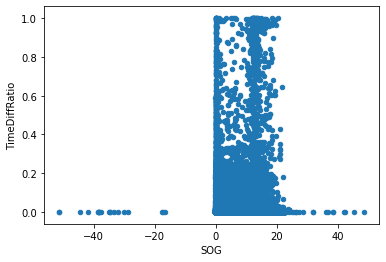

In [0]:
df.plot.scatter('SOG','TimeDiffRatio')

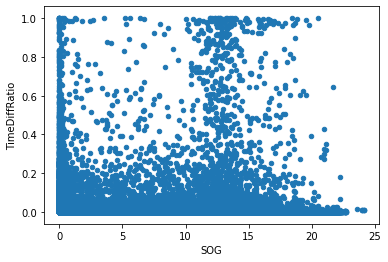

In [0]:
#remove values that are smaller than 0; since speed should be more than 0 and less than 25
df = df[(df['SOG'] >= 0) & (df['SOG'] <= 25) & (df['TimeDiffRatio'] >0.0)]
df.plot.scatter('SOG','TimeDiffRatio')

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df[['SOG','TimeDiffRatio']] = scaler.fit_transform(df[['SOG','TimeDiffRatio']])
df[['SOG','TimeDiffRatio']].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,SOG,TimeDiffRatio
1,0.000000,0.000015
2,0.000000,0.000108
3,0.000000,0.000106
4,0.489627,0.004271
5,0.485477,0.000015


In [0]:
X1 = df['SOG'].values.reshape(-1,1)
X2 = df['TimeDiffRatio'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

In [0]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.005
# Define seven outlier detection tools to be compared
classifiers = {
        # 'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        # 'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        # 'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        # 'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        # 'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        # 'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


OUTLIERS :  5118 INLIERS :  1018798 Cluster-based Local Outlier Factor (CBLOF)


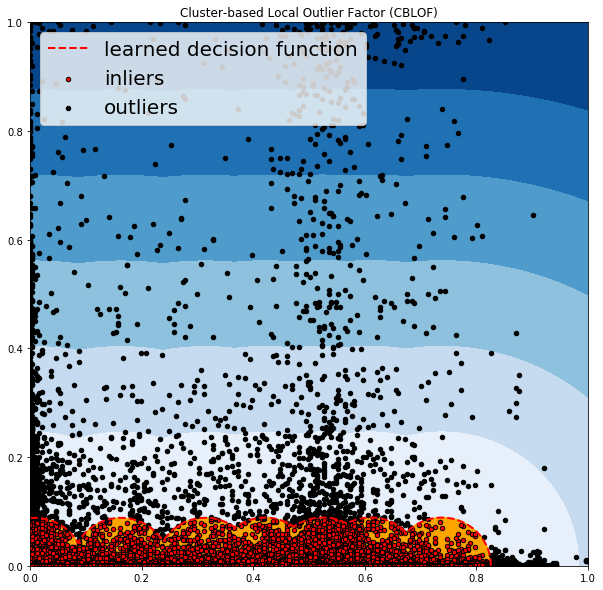

<Figure size 432x288 with 0 Axes>

In [0]:
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['SOG'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['TimeDiffRatio'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['SOG'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['TimeDiffRatio'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='red',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()
    plt.savefig('CBLOF_GRAPH.png')

In [0]:
plt.savefig('CBLOF_GRAPH.png')

<Figure size 432x288 with 0 Axes>

In [0]:
# df['CBLOF Pred'] = y_pred
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,BaseDateTime_UTC,BaseDateTime_UNIX,Date,VesselType_New,TimeDiff,TimeDiffRatio,outlier
1,0,2017-01-24T08:29:42.0000000Z,18.12518,-94.41903,0.000000,-195.6,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 08:29:42,1.485247e+09,2017-01-24,Not Available,150.0,0.000015,0
2,0,2017-01-24T08:47:42.0000000Z,18.12518,-94.41903,0.000000,-195.7,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 08:47:42,1.485248e+09,2017-01-24,Not Available,1080.0,0.000108,0
3,0,2017-01-24T09:05:21.0000000Z,18.12519,-94.41902,0.000000,-195.4,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 09:05:21,1.485249e+09,2017-01-24,Not Available,1059.0,0.000106,0
4,0,2017-01-24T20:56:52.0000000Z,18.79671,-93.43659,0.489627,58.5,59.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 20:56:52,1.485291e+09,2017-01-24,Not Available,42691.0,0.004271,0
5,0,2017-01-24T20:59:25.0000000Z,18.80160,-93.42945,0.485477,59.4,60.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,2017-01-24 20:59:25,1.485292e+09,2017-01-24,Not Available,153.0,0.000015,0


In [0]:
df.to_csv('CBLOF.csv',index=False)